<a href="https://colab.research.google.com/github/shubhamphal/One-NLP/blob/master/ChatBot_with_Memory_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Single Supporting Fact**

In [1]:
from __future__ import print_function, division
from builtins import range, input


import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import re
import tarfile

from keras.models import Model
from keras.layers import Dense, Embedding, Input, Lambda, Reshape, add, dot, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, RMSprop
from keras.utils.data_utils import get_file


In [14]:
path = get_file(
  'babi-tasks-v1-2.tar.gz', 
  origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar = tarfile.open(path)

In [15]:
challenges = {
  # QA1 with 10,000 samples
  'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
  # QA2 with 10,000 samples
  'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
}

In [16]:
def tokenize(sent):
  '''Return the tokens of a sentence including punctuation.
  >>> tokenize('Bob dropped the apple. Where is the apple?')
  ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
  '''
  return [x.strip() for x in re.split('(\W+?)', sent) if x.strip()]


In [17]:
def get_stories(f):
  # data will return a list of triples
  # each triple contains:
  #   1. a story
  #   2. a question about the story
  #   3. the answer to the question
  data = []

  # use this list to keep track of the story so far
  story = []

  # print a random story, helpful to see the data
  printed = False
  for line in f:
    line = line.decode('utf-8').strip()

    # split the line number from the rest of the line
    nid, line = line.split(' ', 1)

    # see if we should begin a new story
    if int(nid) == 1:
      story = []

    # this line contains a question and answer if it has a tab
    #       question<TAB>answer
    # it also tells us which line in the story is relevant to the answer
    # Note: we actually ignore this fact, since the model will learn
    #       which lines are important
    # Note: the max line number is not the number of lines of the story
    #       since lines with questions do not contain any story
    # one story may contain MULTIPLE questions
    if '\t' in line:
      q, a, supporting = line.split('\t')
      q = tokenize(q)

      # numbering each line is very useful
      # it's the equivalent of adding a unique token to the front
      # of each sentence
      story_so_far = [[str(i)] + s for i, s in enumerate(story) if s]

      # uncomment if you want to see what a story looks like
      # if not printed and np.random.rand() < 0.5:
      #     print("story_so_far:", story_so_far)
      #     printed = True
      data.append((story_so_far, q, a))
      story.append('')
    else:
      # just add the line to the current story
      story.append(tokenize(line))
  return data


In [18]:
def should_flatten(el): 
  return not isinstance(el, (str, bytes))

def flatten(l):
  for el in l:
    if should_flatten(el):
      yield from flatten(el)
    else:
      yield el

In [19]:
def vectorize_stories(data, word2idx, story_maxlen, query_maxlen):
  inputs, queries, answers = [], [], []
  for story, query, answer in data:
    inputs.append([[word2idx[w] for w in s] for s in story])
    queries.append([word2idx[w] for w in query])
    answers.append([word2idx[answer]])
  return (
    [pad_sequences(x, maxlen=story_maxlen) for x in inputs],
    pad_sequences(queries, maxlen=query_maxlen),
    np.array(answers)
  )

In [20]:
def stack_inputs(inputs, story_maxsents, story_maxlen):
  for i, story in enumerate(inputs):
    inputs[i] = np.concatenate(
      [
        story, 
        np.zeros((story_maxsents - story.shape[0], story_maxlen), 'int')
      ]
    )
  return np.stack(inputs)

In [21]:
def get_data(challenge_type):
  # input should either be 'single_supporting_fact_10k' or 'two_supporting_facts_10k'
  challenge = challenges[challenge_type]


  # returns a list of triples of:
  # (story, question, answer)
  # story is a list of sentences
  # question is a sentence
  # answer is a word
  train_stories = get_stories(tar.extractfile(challenge.format('train')))
  test_stories = get_stories(tar.extractfile(challenge.format('test')))


  # group all the stories together
  stories = train_stories + test_stories

  # so we can get the max length of each story, of each sentence, and of each question
  story_maxlen = max((len(s) for x, _, _ in stories for s in x))
  story_maxsents = max((len(x) for x, _, _ in stories))
  query_maxlen = max(len(x) for _, x, _ in stories)

  # Create vocabulary of corpus and find size, including a padding element.
  vocab = sorted(set(flatten(stories)))
  vocab.insert(0, '<PAD>')
  vocab_size = len(vocab)

  # Create an index mapping for the vocabulary.
  word2idx = {c:i for i, c in enumerate(vocab)}

  # convert stories from strings to lists of integers
  inputs_train, queries_train, answers_train = vectorize_stories(
    train_stories, 
    word2idx,
    story_maxlen,
    query_maxlen
  )
  inputs_test, queries_test, answers_test = vectorize_stories(
    test_stories, 
    word2idx,
    story_maxlen,
    query_maxlen
  )

  # convert inputs into 3-D numpy arrays
  inputs_train = stack_inputs(inputs_train, story_maxsents, story_maxlen)
  inputs_test = stack_inputs(inputs_test, story_maxsents, story_maxlen)
  print("inputs_train.shape, inputs_test.shape", inputs_train.shape, inputs_test.shape)


  # return model inputs for keras
  return train_stories, test_stories, \
    inputs_train, queries_train, answers_train, \
    inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, \
    vocab, vocab_size

In [22]:
train_stories, test_stories, \
  inputs_train, queries_train, answers_train, \
  inputs_test, queries_test, answers_test, \
  story_maxsents, story_maxlen, query_maxlen, \
  vocab, vocab_size = get_data('single_supporting_fact_10k')




##### create the model #####
embedding_dim = 15


# turn the story into a sequence of embedding vectors
# one for each story line
# treating each story line like a "bag of words"
input_story_ = Input((story_maxsents, story_maxlen))
embedded_story = Embedding(vocab_size, embedding_dim)(input_story_)
embedded_story = Lambda(lambda x: K.sum(x, axis=2))(embedded_story)
print("input_story_.shape, embedded_story.shape:", input_story_.shape, embedded_story.shape)


# turn the question into an embedding
# also a bag of words
input_question_ = Input((query_maxlen,))
embedded_question = Embedding(vocab_size, embedding_dim)(input_question_)
embedded_question = Lambda(lambda x: K.sum(x, axis=1))(embedded_question)

# add a "sequence length" of 1 so that it can
# be dotted with the story later
embedded_question = Reshape((1, embedding_dim))(embedded_question)
print("inp_q.shape, emb_q.shape:", input_question_.shape, embedded_question.shape)


# calculate the weights for each story line
# embedded_story.shape        = (N, num sentences, embedding_dim)
# embedded_question.shape     = (N, 1, embedding_dim)
x = dot([embedded_story, embedded_question], 2)
x = Reshape((story_maxsents,))(x) # flatten the vector
x = Activation('softmax')(x)
story_weights = Reshape((story_maxsents, 1))(x) # unflatten it again to be dotted later
print("story_weights.shape:", story_weights.shape)



x = dot([story_weights, embedded_story], 1)
x = Reshape((embedding_dim,))(x) # flatten it again
ans = Dense(vocab_size, activation='softmax')(x)

# make the model
model = Model([input_story_, input_question_], ans)

# compile the model
model.compile(
  optimizer=RMSprop(lr=1e-2),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

# train the model
r = model.fit(
  [inputs_train, queries_train],
  answers_train,
  epochs=4,
  batch_size=32,
  validation_data=([inputs_test, queries_test], answers_test)
)



inputs_train.shape, inputs_test.shape (10000, 10, 8) (1000, 10, 8)
input_story_.shape, embedded_story.shape: (None, 10, 8) (None, 10, 15)
inp_q.shape, emb_q.shape: (None, 4) (None, 1, 15)
story_weights.shape: (None, 10, 1)
Epoch 1/4
313/313 [==============================] - 1s 3ms/step - loss: 0.8345 - accuracy: 0.6967 - val_loss: 0.0212 - val_accuracy: 0.9950
Epoch 2/4
313/313 [==============================] - 1s 3ms/step - loss: 0.0148 - accuracy: 0.9953 - val_loss: 7.5702e-04 - val_accuracy: 1.0000
Epoch 3/4
313/313 [==============================] - 1s 3ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 7.9822e-06 - val_accuracy: 1.0000
Epoch 4/4
313/313 [==============================] - 1s 3ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0078 - val_accuracy: 0.9970


In [23]:
debug_model = Model([input_story_, input_question_], story_weights)

# choose a random story
story_idx = np.random.choice(len(train_stories))

# get weights from debug model
i = inputs_train[story_idx:story_idx+1]
q = queries_train[story_idx:story_idx+1]
w = debug_model.predict([i, q]).flatten()

story, question, ans = train_stories[story_idx]
print("story:\n")
for i, line in enumerate(story):
  print("{:1.5f}".format(w[i]), "\t", " ".join(line))

print("question:", " ".join(question))
print("answer:", ans)


# pause so we can see the output
input("Hit enter to continue\n\n")

story:

0.00000 	 0 Sandra went to the hallway .
0.00000 	 1 John went back to the bathroom .
0.00001 	 3 Mary went back to the bedroom .
0.00000 	 4 John went to the hallway .
0.00000 	 6 Sandra journeyed to the office .
0.01285 	 7 Mary went back to the kitchen .
0.00000 	 9 John travelled to the kitchen .
0.98714 	 10 Mary went back to the hallway .
question: Where is Mary ?
answer: hallway
Hit enter to continue




''

**Two Supporting Facts**

In [24]:
train_stories, test_stories, \
  inputs_train, queries_train, answers_train, \
  inputs_test, queries_test, answers_test, \
  story_maxsents, story_maxlen, query_maxlen, \
  vocab, vocab_size = get_data('two_supporting_facts_10k')

inputs_train.shape, inputs_test.shape (10000, 88, 8) (1000, 88, 8)


In [25]:
embedding_dim = 30


In [26]:
def embed_and_sum(x, axis=2):
  x = Embedding(vocab_size, embedding_dim)(x)
  x = Lambda(lambda x: K.sum(x, axis))(x)
  return x

In [30]:
input_story_ = Input((story_maxsents, story_maxlen))
input_question_ = Input((query_maxlen,))

embedded_story = embed_and_sum(input_story_)
embedded_question = embed_and_sum(input_question_, 1)

dense_layer = Dense(embedding_dim, activation='elu')

In [31]:
def hop(query, story):
  # query.shape = (embedding_dim,)
  # story.shape = (num sentences, embedding_dim)
  x = Reshape((1, embedding_dim))(query) # make it (1, embedding_dim)
  x = dot([story, x], 2)
  x = Reshape((story_maxsents,))(x) # flatten it for softmax
  x = Activation('softmax')(x)
  story_weights = Reshape((story_maxsents, 1))(x) # unflatten for dotting

  # makes a new embedding
  story_embedding2 = embed_and_sum(input_story_)
  x = dot([story_weights, story_embedding2], 1)
  x = Reshape((embedding_dim,))(x)
  x = dense_layer(x)
  return x, story_embedding2, story_weights

In [32]:
# do the hops
ans1, embedded_story, story_weights1 = hop(embedded_question, embedded_story)
ans2, _,              story_weights2 = hop(ans1,              embedded_story)

# get the final answer
ans = Dense(vocab_size, activation='softmax')(ans2)

In [33]:
# build the model
model2 = Model([input_story_, input_question_], ans)

# compile the model
model2.compile(
  optimizer=RMSprop(lr=5e-3),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

# fit the model
r = model2.fit(
  [inputs_train, queries_train],
  answers_train,
  epochs=30,
  batch_size=32,
  validation_data=([inputs_test, queries_test], answers_test)
)


### print story line weights again ###
debug_model2 = Model(
  [input_story_, input_question_],
  [story_weights1, story_weights2]
)

# choose a random story
story_idx = np.random.choice(len(train_stories))

# get weights from debug model
i = inputs_train[story_idx:story_idx+1]
q = queries_train[story_idx:story_idx+1]
w1, w2 = debug_model2.predict([i, q])
w1 = w1.flatten()
w2 = w2.flatten()

story, question, ans = train_stories[story_idx]
print("story:\n")
for j, line in enumerate(story):
  print("{:1.5f}".format(w1[j]), "\t", "{:1.5f}".format(w2[j]), "\t", " ".join(line))

print("question:", " ".join(question))
print("answer:", ans)
print("prediction:", vocab[ np.argmax(model2.predict([i, q])[0]) ])

Epoch 1/30
313/313 [==============================] - 2s 7ms/step - loss: 1.7605 - accuracy: 0.2522 - val_loss: 1.4927 - val_accuracy: 0.3870
Epoch 2/30
313/313 [==============================] - 2s 6ms/step - loss: 1.0596 - accuracy: 0.5968 - val_loss: 0.9035 - val_accuracy: 0.6710
Epoch 3/30
313/313 [==============================] - 2s 6ms/step - loss: 0.7608 - accuracy: 0.7248 - val_loss: 0.7707 - val_accuracy: 0.6960
Epoch 4/30
313/313 [==============================] - 2s 6ms/step - loss: 0.5833 - accuracy: 0.7812 - val_loss: 0.5874 - val_accuracy: 0.7730
Epoch 5/30
313/313 [==============================] - 2s 6ms/step - loss: 0.4570 - accuracy: 0.8363 - val_loss: 0.4888 - val_accuracy: 0.8330
Epoch 6/30
313/313 [==============================] - 2s 7ms/step - loss: 0.3937 - accuracy: 0.8602 - val_loss: 0.5112 - val_accuracy: 0.8390
Epoch 7/30
313/313 [==============================] - 2s 6ms/step - loss: 0.3395 - accuracy: 0.8838 - val_loss: 0.4896 - val_accuracy: 0.8420
Epoch 

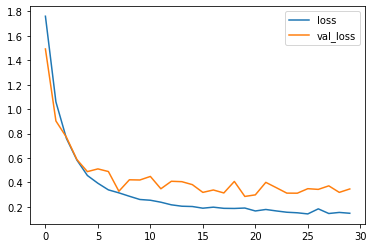

In [35]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()



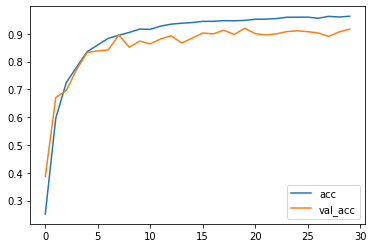

In [36]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()